In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 10.2 MB/s eta 0:00:00


In [2]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 6.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from math import sqrt
import os
import missingno as msno
import calendar
import datetime
from math import sqrt

#시각화
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

#preprocessing
from sklearn.metrics import mean_squared_error, mean_squared_log_error, make_scorer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import Lasso,Ridge
from sklearn.pipeline import Pipeline

#models
import lightgbm as lgbm

#최적화
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

#Xai
from functools import partial 
import shap

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### 데이터 준비

In [6]:
test_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/test_eda.csv"
train_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/train_eda.csv"

test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

test.drop("Unnamed: 0", axis=1, inplace=True)
train.drop("Unnamed: 0", axis=1, inplace=True)

In [7]:
#cat features
cat_col = ["season", "Year","weather", "Day of week","Month", "Hour","Day_info"]
for col in cat_col:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

#train, valid split
days = list(range(1, 15))
train_d = train.loc[train['Day'].isin(days)]
test_d = train.loc[~(train['Day'].isin(days))]

#target, drop, y
target_col = "count"
drop_cols = ["datetime", "workingday", "holiday", "Day", "Year","sin_hour", "cos_hour", target_col]

x_train, y_train = train_d.drop(drop_cols, axis=1), train_d[target_col]
x_test, y_test = test_d.drop(drop_cols, axis=1), test_d[target_col]

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

x_train.head()

,season,weather,temp,humidity,windspeed,Day of week,Month,Hour,Day_info
0,1,Good,9.84,81,0.0,Saturday,1,0,Weekend
1,1,Good,9.02,80,0.0,Saturday,1,1,Weekend
2,1,Good,9.02,80,0.0,Saturday,1,2,Weekend
3,1,Good,9.84,75,0.0,Saturday,1,3,Weekend
4,1,Good,9.84,75,0.0,Saturday,1,4,Weekend


In [8]:
x_train.shape

(8026, 9)

In [9]:
x_test.shape

(2860, 9)

In [10]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8026 entries, 0 to 8025
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   season       8026 non-null   category
 1   weather      8026 non-null   category
 2   temp         8026 non-null   float64 
 3   humidity     8026 non-null   int64   
 4   windspeed    8026 non-null   float64 
 5   Day of week  8026 non-null   category
 6   Month        8026 non-null   category
 7   Hour         8026 non-null   category
 8   Day_info     8026 non-null   category
dtypes: category(6), float64(2), int64(1)
memory usage: 237.2 KB


### optuna

In [11]:
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.expm1(y_true)
        y_pred = np.expm1(y_pred)
        
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

In [12]:
def objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "metric": "regression",
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.01),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }

    n_splits=5
    random_state=42
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = []

    #local_train, local_valid를 5번 만들어서 수행
    for train_index, valid_index in kf.split(X=x_train, y=y_train):
        X_train, Y_train = x_train.iloc[train_index], np.log1p(y_train[train_index])
        X_valid, Y_valid = x_train.iloc[valid_index], np.log1p(y_train[valid_index])

        model = lgbm.LGBMRegressor(**params_lgb)
        model.fit(
            X_train,
            Y_train,
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
            early_stopping_rounds=100,
            verbose=False
        )

        lgb_pred = model.predict(X_valid)
        scores.append(rmsle(Y_valid, lgb_pred))

    return np.mean(scores)

In [13]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=50)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-03-23 07:24:46,990] A new study created in memory with name: lgbm_parameter_opt
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
'early_stopping_rounds' argument is deprecated and will be removed in a futu

Best Score: 0.34344369440090344
Best trial: {'n_estimators': 1887, 'learning_rate': 0.009941017555079366, 'reg_alpha': 2.4362004007915715e-05, 'reg_lambda': 0.0646440725642828, 'max_depth': 15, 'num_leaves': 88, 'colsample_bytree': 0.7401728771840006, 'subsample': 0.9557226914569007, 'subsample_freq': 9, 'min_child_samples': 41, 'max_bin': 415}


In [14]:
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

Best Score: 0.34344369440090344
Best trial: {'n_estimators': 1887, 'learning_rate': 0.009941017555079366, 'reg_alpha': 2.4362004007915715e-05, 'reg_lambda': 0.0646440725642828, 'max_depth': 15, 'num_leaves': 88, 'colsample_bytree': 0.7401728771840006, 'subsample': 0.9557226914569007, 'subsample_freq': 9, 'min_child_samples': 41, 'max_bin': 415}


In [15]:
# 시각화
optuna.visualization.plot_optimization_history(study)

In [16]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

In [ ]:
# # 파라미터들관의 관계
# optuna.visualization.plot_parallel_coordinate(study)

#모델 학습습
# op_tuned = lgbm.LGBMRegressor(**study.best_trial.params)
# op_tuned.fit(x_train, np.log(y_train),
#              eval_set=[(x_train,np.log( y_train)), (x_test, np.log(y_test))],
#             eval_metric="rmse")

In [17]:
op_tuned = lgbm.LGBMRegressor(**study.best_trial.params)
op_tuned.fit(x_train, np.log(y_train))

LGBMRegressor(colsample_bytree=0.7401728771840006,
              learning_rate=0.009941017555079366, max_bin=415, max_depth=15,
              min_child_samples=41, n_estimators=1887, num_leaves=88,
              reg_alpha=2.4362004007915715e-05, reg_lambda=0.0646440725642828,
              subsample=0.9557226914569007, subsample_freq=9)

In [21]:
lgb_pred = op_tuned.predict(x_test)
x_test["y_pred"] = np.expm1(lgb_pred)
test_rm = rmsle(y_test, x_test["y_pred"], False)
print("RMSLE", test_rm)

RMSLE 0.4164747293202174


In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=x_test["y_pred"], mode="markers", name="test_predict"))
fig.add_trace(go.Scatter(x=y_test, y=y_test, mode="lines", name="test_real"))
fig.update_layout(
    autosize=False,
    width=600,
    height=600,
)
fig.update_layout(title=dict({"text": f"RMSLE: {test_rm}"}))
fig.update_layout(xaxis=dict({"title": "Real"}))
fig.update_layout(yaxis=dict({"title": "Predict"}))
fig.show()

최종 전체 학습후 평가제출

In [23]:
x_train.head()

,season,weather,temp,humidity,windspeed,Day of week,Month,Hour,Day_info
0,1,Good,9.84,81,0.0,Saturday,1,0,Weekend
1,1,Good,9.02,80,0.0,Saturday,1,1,Weekend
2,1,Good,9.02,80,0.0,Saturday,1,2,Weekend
3,1,Good,9.84,75,0.0,Saturday,1,3,Weekend
4,1,Good,9.84,75,0.0,Saturday,1,4,Weekend


In [26]:
target_col = "count"
drop_cols = ["datetime", "workingday", "holiday", "Day", "cos_hour", "sin_hour", "Year", target_col]

X_final_train, y_final_train = train.drop(drop_cols, axis=1), train[target_col]
X_final_test= test.drop(["datetime", "workingday", "holiday", "Day", "cos_hour", "sin_hour", "Year"], axis=1)

op_tuned_final = lgbm.LGBMRegressor(**study.best_trial.params)
op_tuned_final.fit(X_final_train, np.log1p(y_final_train))

sub_pred = op_tuned_final.predict(X_final_test)
sub_pred = np.expm1(sub_pred)

test["count"] = sub_pred
submission = test[["datetime", "count"]]
submission.head()

,datetime,count
0,2011-01-20 00:00:00,17.209660
1,2011-01-20 01:00:00,5.681836
2,2011-01-20 02:00:00,4.095883
3,2011-01-20 03:00:00,4.131118
4,2011-01-20 04:00:00,3.116397


In [30]:
X_final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   season       6493 non-null   category
 1   weather      6493 non-null   category
 2   temp         6493 non-null   float64 
 3   humidity     6493 non-null   int64   
 4   windspeed    6493 non-null   float64 
 5   Day of week  6493 non-null   category
 6   Month        6493 non-null   category
 7   Hour         6493 non-null   category
 8   Day_info     6493 non-null   category
dtypes: category(6), float64(2), int64(1)
memory usage: 192.3 KB


### SHap value

In [ ]:
import shap

In [61]:
explainer = shap.TreeExplainer(op_tuned_final)
shap_values = explainer.shap_values(X_final_train)

/usr/local/lib/python3.9/dist-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



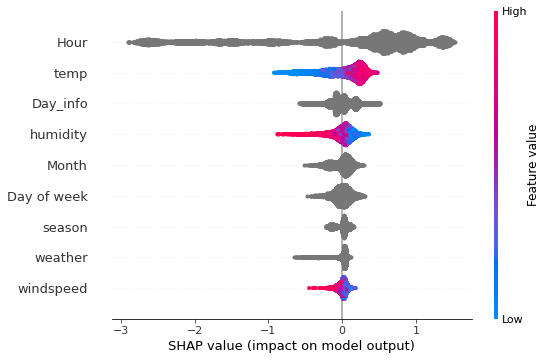

In [62]:
shap.summary_plot(shap_values,X_final_train)

In [90]:
print(explainer.expected_value)

4.591032615208921


In [81]:
len(shap_values[:,0])

10886

In [79]:
shap.plots._waterfall.(explainer.expected_value,shap_values[0, :],
                        feature_names=X_final_train.columns)
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0, :],


SyntaxError: ignored

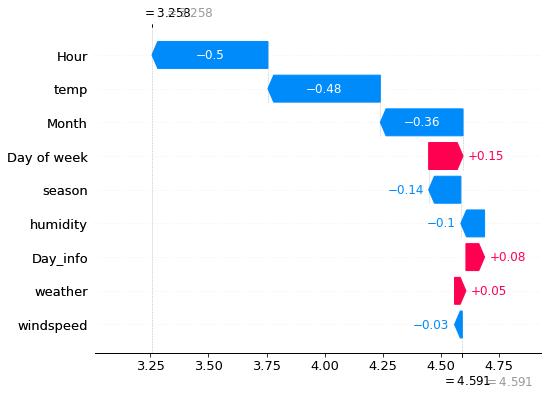

In [86]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value,shap_values[0,:],
                                        feature_names=X_final_train.columns)

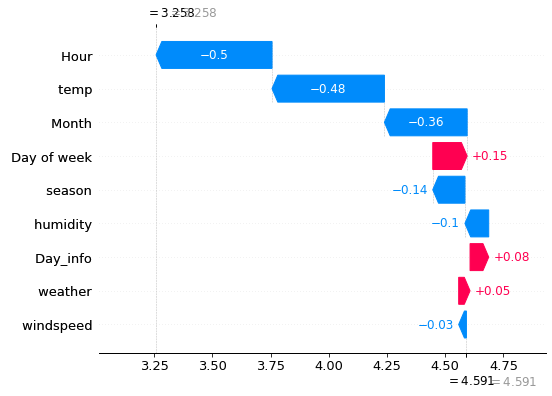

In [100]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0, :], features=X_final_train.iloc[0, :])

In [93]:
# Outlier 에 대한 SHAP 시각화 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_final_train.iloc[0,:])

In [96]:
X_final_train.iloc[0,:]

season                1
weather            Good
temp               9.84
humidity             81
windspeed           0.0
Day of week    Saturday
Month                 1
Hour                  0
Day_info        Weekend
Name: 0, dtype: object

In [97]:
np.expm1(3.258)

24.997490132592233

In [98]:
y_train[0]

16

In [99]:
op_tuned_final.predict(X_final_train)[0]

3.2578186260867046